# Random Forest: Prediction of Austral Summer Precipitation

In [2]:
import os
import glob  
import sys
from multiprocessing import Pool 
import time 
import numpy as np
import rasterio
import multiprocessing
import matplotlib.pyplot as plt
import xarray as xr
import dask
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.patches as patches
import cartopy.feature as cfeature

In [3]:
#SST data
mon_precip_sa = xr.open_dataset('/home/k16v981/my_work/data/era5/era5_mon_precip_sa.nc')

mon_sst_anom = xr.open_dataset('/home/k16v981/my_work/data/era5/era5_sst_month_anom.nc')

mon_sst_anom =  mon_sst_anom.sortby('valid_time')

mon_sst_anom = mon_sst_anom.rename({'valid_time': 'date'})

new_dates = pd.to_datetime(mon_sst_anom.coords['date']).to_period('M').start_time
mon_sst_anom = mon_sst_anom.assign_coords(date=new_dates)

In [4]:
#Precipitation data
mon_precip_sa['date'] = pd.to_datetime(mon_precip_sa['date'].values.astype(str), format='%Y%m%d')

lat_min, lat_max = -25, -12  
lon_min, lon_max = 17, 32

mon_precip_zambia = mon_precip_sa.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))
mon_precip_zambia_mean = mon_precip_zambia.mean(dim=('latitude', 'longitude'))

o_f_precip_zambia_mean = mon_precip_zambia_mean.sel(date=(mon_precip_zambia_mean['date.month'] >= 10) | (mon_precip_zambia_mean['date.month'] <= 2))
o_f_precip_zambia_mean

<xarray.Dataset> Size: 11kB
Dimensions:  (date: 405)
Coordinates:
    number   int64 8B ...
  * date     (date) datetime64[ns] 3kB 1940-01-01 1940-02-01 ... 2020-12-01
    expver   (date) <U4 6kB ...
Data variables:
    tp       (date) float32 2kB 0.006553 0.003822 ... 0.003284 0.007111

In [5]:
mon_geopot_sa = xr.open_dataset('/home/k16v981/my_work/data/era5/era5_mon_geopot_sa.nc')
mon_geopot_sa['date'] = pd.to_datetime(mon_geopot_sa['date'].values.astype(str), format='%Y%m%d')
mon_geopot_sa = mon_geopot_sa.sel(date=slice(None, '2020-12-01'))

mon_geopot_zambia = mon_geopot_sa.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))
mon_geopot_zambia_mean = mon_geopot_zambia.mean(dim=('latitude', 'longitude'))

o_f_geopot_zambia_mean= mon_geopot_zambia_mean.sel(date=(mon_geopot_sa['date.month'] >= 10) | (mon_geopot_sa['date.month'] <= 2))
o_f_geopot_zambia_mean

<xarray.Dataset> Size: 11kB
Dimensions:         (date: 405, pressure_level: 1)
Coordinates:
    number          int64 8B ...
  * date            (date) datetime64[ns] 3kB 1940-01-01 ... 2020-12-01
  * pressure_level  (pressure_level) float64 8B 500.0
    expver          (date) <U4 6kB ...
Data variables:
    z               (date, pressure_level) float32 2kB 5.724e+04 ... 5.758e+04

In [6]:
#El Nino Data Prep
nino34 = mon_sst_anom['sst'].sel(
    longitude=slice(190, 240),  
    latitude=slice(5, -5)         
)

mean_nino34 = nino34.mean(dim=('latitude', 'longitude'))

o_f_nino = mean_nino34.sel(date=(mean_nino34['date.month'] >= 10) | (mean_nino34['date.month'] <= 2))

#IOD data
west_region_iod = mon_sst_anom['sst'].sel(
    longitude=slice(50, 70),  # Longitude range
    latitude=slice(10, -10)        # Latitude range
)

east_region_iod = mon_sst_anom['sst'].sel(
    longitude=slice(90, 110),  # Longitude range
    latitude=slice(10, -10)        # Latitude range
)

west_region_iod = west_region_iod.mean(dim=('latitude', 'longitude'))
east_region_iod = east_region_iod.mean(dim=('latitude', 'longitude'))

iod_index = west_region_iod - east_region_iod

o_f_iod = iod_index.sel(date=(iod_index['date.month'] >= 10) | (iod_index['date.month'] <= 2))

#step up ABFZ
abfz = mon_sst_anom['sst'].sel(
    longitude=(mon_sst_anom['sst'].longitude < 15) | (mon_sst_anom['sst'].longitude > 355),
    latitude=slice(-10, -20)  
)

mean_abfz = abfz.mean(dim=('latitude', 'longitude'))

o_f_abfz = mean_abfz.sel(date=(mean_abfz['date.month'] >= 10) | (mean_abfz['date.month'] <= 2))

#Set Up EMI
#box A: (165°E-140°W, 10°S-10°N)
box_a = mon_sst_anom['sst'].sel(
    longitude=slice(165, 220),  
    latitude=slice(10, -10)         
)
#Box B: (110°W-70°W, 15°S-5°N)
box_b = mon_sst_anom['sst'].sel(
    longitude=slice(250, 290),  
    latitude=slice(5, -15)         
)
#Box C: (125°E-145°E, 10°S-20°N)
box_c = mon_sst_anom['sst'].sel(
    longitude=slice(125, 145),  
    latitude=slice(20, -10)         
)

mean_box_a = box_a.mean(dim=('latitude', 'longitude'))

mean_box_b = box_b.mean(dim=('latitude', 'longitude'))

mean_box_c = box_c.mean(dim=('latitude', 'longitude'))

EMI = mean_box_a - (0.5 * mean_box_b) - (0.5 * mean_box_c)

o_f_EMI = EMI.sel(date=(EMI['date.month'] >= 10) | (EMI['date.month'] <= 2))

In [7]:
# I want to lag the sst by 1, 2, and 3 months to test in lagged sst predict precipitation
sept_jan_nino = mean_nino34.sel(date=(mean_nino34['date.month'] >= 9) | (mean_nino34['date.month'] <= 1))
sept_jan_iod = iod_index.sel(date=(iod_index['date.month'] >= 9) | (iod_index['date.month'] <= 1))
sept_jan_abfz = mean_abfz.sel(date=(mean_abfz['date.month'] >= 9) | (mean_abfz['date.month'] <= 1))
sept_jan_EMI = EMI.sel(date=(EMI['date.month'] >= 9) | (EMI['date.month'] <= 1))

sept_jan_nino = pd.DataFrame({"nino_lag_1": sept_jan_nino})
sept_jan_iod = pd.DataFrame({"iod_lag_1": sept_jan_iod})
sept_jan_abfz = pd.DataFrame({"abfz_lag_1": sept_jan_abfz})
sept_jan_EMI = pd.DataFrame({"EMI_lag_1": sept_jan_EMI})

aug_dec_nino = mean_nino34.sel(date=mean_nino34['date.month'].isin([8, 9, 10, 11, 12]))
aug_dec_iod = iod_index.sel(date=iod_index['date.month'].isin([8, 9, 10, 11, 12]))
aug_dec_abfz = mean_abfz.sel(date=mean_abfz['date.month'].isin([8, 9, 10, 11, 12]))
aug_dec_EMI = EMI.sel(date=EMI['date.month'].isin([8, 9, 10, 11, 12]))

aug_dec_nino = pd.DataFrame({"nino_lag_2": aug_dec_nino})
aug_dec_iod = pd.DataFrame({"iod_lag_2": aug_dec_iod})
aug_dec_abfz = pd.DataFrame({"abfz_lag_2": aug_dec_abfz})
aug_dec_EMI = pd.DataFrame({"EMI_lag_2": aug_dec_EMI})

july_nov_nino = mean_nino34.sel(date=mean_nino34['date.month'].isin([7, 8, 9, 10, 11]))
july_nov_iod = iod_index.sel(date=iod_index['date.month'].isin([7, 8, 9, 10, 11]))
july_nov_abfz = mean_abfz.sel(date=mean_abfz['date.month'].isin([7, 8, 9, 10, 11]))
july_nov_EMI = EMI.sel(date=EMI['date.month'].isin([7, 8, 9, 10, 11]))

july_nov_nino = pd.DataFrame({"nino_lag_3": july_nov_nino})
july_nov_iod = pd.DataFrame({"iod_lag_3": july_nov_iod})
july_nov_abfz = pd.DataFrame({"abfz_lag_3": july_nov_abfz})
july_nov_EMI = pd.DataFrame({"EMI_lag_3": july_nov_EMI})

### Take all these values of SST etc, and turn them into predictors

In [8]:
o_f_geopot_zambia_mean['z'] = np.squeeze(o_f_geopot_zambia_mean['z'])

target_df = pd.DataFrame({"precipitation": o_f_precip_zambia_mean['tp']})
pred1_df = pd.DataFrame({"iod": o_f_iod})
pred2_df = pd.DataFrame({"nino": o_f_nino})
pred3_df = pd.DataFrame({"abfz": o_f_abfz})
pred4_df = pd.DataFrame({"z": o_f_geopot_zambia_mean['z']})
pred5_df = pd.DataFrame({"EMI": o_f_EMI})

# Combine predictors into a single DataFrame
predictors_df = pd.concat([pred1_df, pred2_df, pred3_df, pred4_df, pred5_df, \
                            sept_jan_nino, sept_jan_iod, sept_jan_abfz, sept_jan_EMI, \
                          aug_dec_nino, aug_dec_iod, aug_dec_abfz, aug_dec_EMI, \
                          july_nov_nino, july_nov_iod, july_nov_abfz, july_nov_EMI], axis=1)

In [9]:
#Split the data 80/20
from sklearn.model_selection import train_test_split

X = predictors_df
y = target_df['precipitation']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Set up the Random Forest Regression Analysis

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 4.038890130473321e-06
R^2 Score: 0.23372185922662403


### We want to find what estimators were doing the best predicting

In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

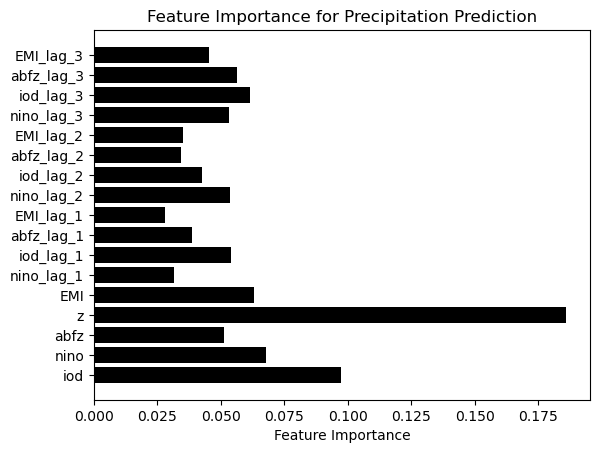

In [12]:
importances = best_model.feature_importances_
features = X.columns

plt.barh(features, importances, color = 'black')
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Precipitation Prediction')

plt.savefig('/home/k16v981/my_work/figures/southern_africa/ranforest_feature_import_sst.jpg', format='jpg')

plt.show()

In [13]:
weights = importances / sum(importances)  # Normalize
print('Weights:', weights)

Weights: [0.09729705 0.06777026 0.05139935 0.18605018 0.06310557 0.03170502
 0.05420552 0.0385333  0.02811068 0.05369059 0.0424639  0.03416518
 0.03527046 0.05320941 0.06147562 0.05626518 0.04528272]


In [14]:
#Use weights above to create a drought index for southern africa
drought_index = ((pred1_df["iod"] * weights[0]) + (pred2_df["nino"] * weights[1]) + (pred3_df["abfz"] * weights[2]) + (pred4_df["z"] * weights[3]) + pred5_df['EMI'] * weights[4] + \
                            sept_jan_nino["nino_lag_1"] * weights[5] + sept_jan_iod["iod_lag_1"] * weights[6] + sept_jan_abfz["abfz_lag_1"] * weights[7] + \
                          aug_dec_nino["nino_lag_2"] * weights[8] + aug_dec_iod["iod_lag_2"] * weights[9] + aug_dec_abfz["abfz_lag_2"] * weights[10] + \
                          july_nov_nino["nino_lag_3"] * weights[11] + july_nov_iod["iod_lag_3"] * weights[12] + july_nov_abfz["abfz_lag_3"] * weights[13])/ sum(weights)
drought_index

0      10648.981445
1      10678.701172
2      10700.949219
3      10658.891602
4      10687.360352
           ...     
400    10737.463867
401    10745.498047
402    10740.416016
403    10732.046875
404    10711.881836
Length: 405, dtype: float32

In [15]:
def normalize(data):
    min_value = min(data)
    max_value = max(data)
    
    normalized_data = [(x - min_value) / (max_value - min_value) for x in data]
    normalized_data = pd.DataFrame({"index": normalized_data}).astype(float)
    
    return normalized_data

In [16]:
drought_index = normalize(drought_index)
drought_index

,index
0,0.062090
1,0.302985
2,0.483318
3,0.142417
4,0.373172
...,...
400,0.779290
401,0.844411
402,0.803218
403,0.735382


In [17]:
o_f_precip_zambia_mean_df = pd.DataFrame({'total precip': o_f_precip_zambia_mean['tp'], \
                                        'date': o_f_precip_zambia_mean['date']})

precip_index = pd.concat([o_f_precip_zambia_mean_df, drought_index], axis=1)
precip_index

,total precip,date,index
0,0.006553,1940-01-01,0.062090
1,0.003822,1940-02-01,0.302985
2,0.000527,1940-10-01,0.483318
3,0.002348,1940-11-01,0.142417
4,0.005576,1940-12-01,0.373172
...,...,...,...
400,0.005803,2020-01-01,0.779290
401,0.007153,2020-02-01,0.844411
402,0.000681,2020-10-01,0.803218
403,0.003284,2020-11-01,0.735382


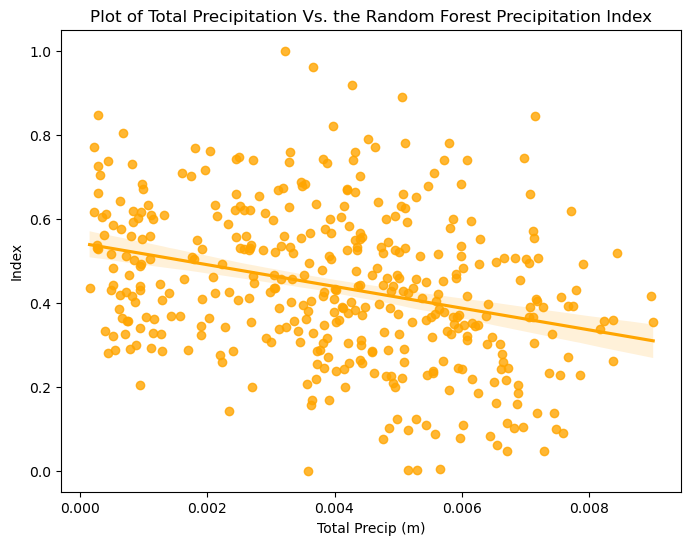

In [18]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.regplot(precip_index, x='total precip', y='index', color='orange')
plt.title('Plot of Total Precipitation Vs. the Random Forest Precipitation Index')
plt.xlabel('Total Precip (m)')
plt.ylabel('Index')
plt.grid(False)

plt.savefig('/home/k16v981/my_work/figures/southern_africa/ranforest_precip_index.jpg', format='jpg')

plt.show()